# Crop Recommendation Model Comparison

This notebook compares Random Forest and XGBoost classifiers for crop recommendation using the provided dataset. It includes data loading, preprocessing, training, evaluation, and feature importance visualization.

In [2]:
# Load all datasets
import pandas as pd

recommendation_df = pd.read_csv('datasets/Crop_recommendation.csv')
yield_df = pd.read_csv('datasets/crop_yield.csv')
price_df = pd.read_csv('datasets/Price_Agriculture_commodities_Week.csv')

print("Recommendation data shape:", recommendation_df.shape)
print("Yield data shape:", yield_df.shape)
print("Price data shape:", price_df.shape)

Recommendation data shape: (2200, 8)
Yield data shape: (19689, 10)
Price data shape: (23093, 10)


In [3]:
import numpy as np

# Suitability check: Is the crop suitable for the state?
def is_crop_suitable(yield_df, state, crop):
    data = yield_df[
        (yield_df['State'].str.lower() == state.lower()) &
        (yield_df['Crop'].str.lower() == crop.lower())
    ]
    return (not data.empty), data

# Get yield stats for a crop in a state
def get_crop_stats(data):
    return {
        'Average Yield': round(data['Yield'].mean(), 2),
        'Max Yield': round(data['Yield'].max(), 2),
        'Min Yield': round(data['Yield'].min(), 2),
        'Years of Data': data['Crop_Year'].nunique()
    }

# Get average modal market price for a crop
def get_average_price(price_df, crop):
    crop_data = price_df[price_df['Commodity'].str.lower() == crop.lower()]
    if not crop_data.empty:
        return round(crop_data['Modal Price'].mean(), 2)
    return None

# Recommend a crop using a trained model
def recommend_crop(model, label_encoder, soil_data, X):
    soil_df = pd.DataFrame([soil_data], columns=X.columns)
    prediction = model.predict(soil_df)[0]
    crop = label_encoder.inverse_transform([prediction])[0]
    return crop

# Polyculture crop suggestions
def get_polyculture_suggestions(crop, soil_data, recommendation_df, yield_df, price_df, state):
    crop = crop.lower()
    df = recommendation_df.copy()
    df['label'] = df['label'].str.lower()
    input_vec = np.array([soil_data[col] for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']])
    df['distance'] = df.drop('label', axis=1).apply(lambda row: np.linalg.norm(input_vec - row.values), axis=1)
    similar_crops = df[df['label'] != crop].sort_values('distance').drop_duplicates('label')
    suggestions = []
    for rc in similar_crops['label'].head(5):
        data = yield_df[yield_df['Crop'].str.lower() == rc.lower()]
        price = get_average_price(price_df, rc)
        if not data.empty:
            suggestions.append({
                'Crop': rc.capitalize(),
                'Average Yield': round(data['Yield'].mean(), 2),
                'Estimated Price': price if price else "N/A"
            })
    return suggestions

# Readable explanation for why a crop is not suitable
def explain_feature_impact_readable(feature, impact, crop):
    direction = "high" if impact > 0 else "low"
    return f"⚠️ {feature.capitalize()} is too {direction} for growing {crop.capitalize()}."

In [4]:
def analyze_crop(model, label_encoder, yield_df, price_df, recommendation_df, state, input_crop, soil_data, X, feature_impacts=None):
    suitable, data = is_crop_suitable(yield_df, state, input_crop)
    if suitable:
        stats = get_crop_stats(data)
        price = get_average_price(price_df, input_crop)
        polyculture_suggestions = get_polyculture_suggestions(input_crop, soil_data, recommendation_df, yield_df, price_df, state)
        return {
            'Status': 'Suitable',
            'Crop': input_crop,
            **stats,
            'Average Market Price': price,
            'Polyculture Suggestions': polyculture_suggestions
        }
    else:
        recommended_crop = recommend_crop(model, label_encoder, soil_data, X)
        explanations = feature_impacts if feature_impacts else []
        suitable, new_data = is_crop_suitable(yield_df, state, recommended_crop)
        stats = get_crop_stats(new_data) if suitable else {}
        price = get_average_price(price_df, recommended_crop)
        polyculture_suggestions = get_polyculture_suggestions(input_crop, soil_data, recommendation_df, yield_df, price_df, state)
        return {
            'Status': 'Not Suitable',
            'Recommended Crop': recommended_crop,
            'Why Not Suitable': explanations,
            **stats,
            'Average Market Price': price,
            'Polyculture Suggestions': polyculture_suggestions
        }

In [5]:
# Example: Analyze a crop for given inputs

from sklearn.preprocessing import LabelEncoder

# Prepare features and label encoder
X = recommendation_df.drop('label', axis=1)
y = recommendation_df['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train Random Forest (or XGBoost as desired)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_encoded)

# User input (edit these values as needed)
state = "Karnataka"
input_crop = "rice"
soil = {
    'N': 90, 'P': 42, 'K': 43, 'temperature': 20, 'humidity': 82, 'ph': 6.5, 'rainfall': 202.9
}

# Feature impact: use feature importances as a proxy (since SHAP is not run here)
feature_impacts = sorted(zip(X.columns, rf.feature_importances_), key=lambda x: abs(x[1]), reverse=True)[:3]

# Run analysis
result = analyze_crop(
    rf, le, yield_df, price_df, recommendation_df, state, input_crop, soil, X,
    feature_impacts=[(f, imp) for f, imp in feature_impacts]
)

# Display results
if result['Status'] == 'Suitable':
    print(f"✅ {input_crop.capitalize()} is suitable for your conditions!\n")
    for key, value in result.items():
        if key not in ['Status', 'Crop', 'Polyculture Suggestions']:
            print(f"{key}: {value}")
else:
    print(f"❌ {input_crop.capitalize()} is not suitable for your conditions.")
    print(f"🌱 Recommended crop: {result['Recommended Crop'].capitalize()}")
    print("Why Not Suitable:")
    for feature, impact in result['Why Not Suitable']:
        print("-", explain_feature_impact_readable(feature, impact, input_crop))
    for key, value in result.items():
        if key not in ['Status', 'Recommended Crop', 'Why Not Suitable', 'Polyculture Suggestions']:
            print(f"{key}: {value}")

if result['Polyculture Suggestions']:
    print("\n🌿 Polyculture Suggestions:")
    for suggestion in result['Polyculture Suggestions']:
        print(f"- {suggestion['Crop']}: Yield={suggestion['Average Yield']} tons/ha, Price=₹{suggestion['Estimated Price']}")

✅ Rice is suitable for your conditions!

Average Yield: 2.61
Max Yield: 4.25
Min Yield: 1.84
Years of Data: 23
Average Market Price: 3185.38

🌿 Polyculture Suggestions:
- Jute: Yield=7.56 tons/ha, Price=₹5331.43


In [6]:
# XGBoost-based crop recommendation analysis

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Prepare features and label encoder
X = recommendation_df.drop('label', axis=1)
y = recommendation_df['label']
le_xgb = LabelEncoder()
y_encoded_xgb = le_xgb.fit_transform(y)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42,eval_metric='mlogloss')
xgb.fit(X, y_encoded_xgb)

# User input (edit these values as needed)
state = "Karnataka"
input_crop = "rice"
soil = {
    'N': 90, 'P': 42, 'K': 43, 'temperature': 20, 'humidity': 82, 'ph': 6.5, 'rainfall': 202.9
}

# Feature impact: use feature importances as a proxy
feature_impacts_xgb = sorted(zip(X.columns, xgb.feature_importances_), key=lambda x: abs(x[1]), reverse=True)[:3]

# Run analysis
result_xgb = analyze_crop(
    xgb, le_xgb, yield_df, price_df, recommendation_df, state, input_crop, soil, X,
    feature_impacts=[(f, imp) for f, imp in feature_impacts_xgb]
)

# Display results
if result_xgb['Status'] == 'Suitable':
    print(f"✅ {input_crop.capitalize()} is suitable for your conditions! (XGBoost)\n")
    for key, value in result_xgb.items():
        if key not in ['Status', 'Crop', 'Polyculture Suggestions']:
            print(f"{key}: {value}")
else:
    print(f"❌ {input_crop.capitalize()} is not suitable for your conditions. (XGBoost)")
    print(f"🌱 Recommended crop: {result_xgb['Recommended Crop'].capitalize()}")
    print("Why Not Suitable:")
    for feature, impact in result_xgb['Why Not Suitable']:
        print("-", explain_feature_impact_readable(feature, impact, input_crop))
    for key, value in result_xgb.items():
        if key not in ['Status', 'Recommended Crop', 'Why Not Suitable', 'Polyculture Suggestions']:
            print(f"{key}: {value}")

if result_xgb['Polyculture Suggestions']:
    print("\n🌿 Polyculture Suggestions:")
    for suggestion in result_xgb['Polyculture Suggestions']:
        print(f"- {suggestion['Crop']}: Yield={suggestion['Average Yield']} tons/ha, Price=₹{suggestion['Estimated Price']}")

✅ Rice is suitable for your conditions! (XGBoost)

Average Yield: 2.61
Max Yield: 4.25
Min Yield: 1.84
Years of Data: 23
Average Market Price: 3185.38

🌿 Polyculture Suggestions:
- Jute: Yield=7.56 tons/ha, Price=₹5331.43


In [11]:
X_noisy = X.copy()
noise_factor = 0.2  
for col in X_noisy.columns:
    std = X_noisy[col].std()
    X_noisy[col] += np.random.normal(0, noise_factor * std, size=X_noisy.shape[0])

y_noisy = y_encoded.copy()
noise_percent = 0.1  
n_noisy = int(noise_percent * len(y_noisy))
noisy_indices = np.random.choice(len(y_noisy), n_noisy, replace=False)
y_noisy[noisy_indices] = np.random.choice(np.unique(y_noisy), n_noisy)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare features and labels
X = recommendation_df.drop('label', axis=1)
y = recommendation_df['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y_noisy, test_size=0.2, random_state=42, stratify=y_noisy
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy:      {xgb_acc:.4f}")

if rf_acc > xgb_acc:
    print("Random Forest performed better.")
elif xgb_acc > rf_acc:
    print("XGBoost performed better.")
else:
    print("Both models performed equally.")

Random Forest Accuracy: 0.8500
XGBoost Accuracy:      0.8114
Random Forest performed better.


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Calculate metrics for Random Forest
rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf, average='weighted', zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)
}

# Calculate metrics for XGBoost
xgb_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
}

# Create DataFrame for table
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics], index=["Random Forest", "XGBoost"])
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.850000,0.854308,0.850000,0.850336
XGBoost,0.811364,0.818407,0.811364,0.812218


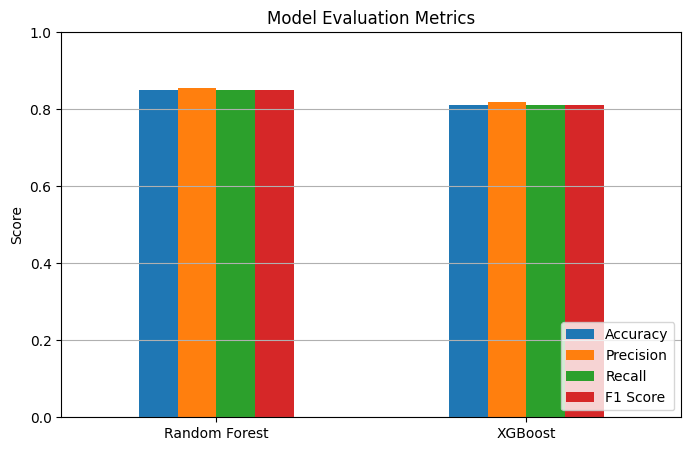

In [14]:
import matplotlib.pyplot as plt

metrics_df.plot(kind='bar', figsize=(8,5))
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()